# A2C Model for RLPaint

## Imports

In [6]:
# Full imports
import gym
import cv2

# Partial imports 
from tqdm.notebook import tqdm, trange
from telesketch.envs.discrete_telesketch import DiscreteTelesketchEnv

# Aliased imports
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
import numpy as np
from typing import Any, List, Sequence, Tuple

## Bootstrap

In [2]:
# Remember to export to export "LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/"" if using linux
# Drop numa errors in term: "for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done"

# Check if we have GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Constants

In [3]:
# Define min epsilon so we don't run into inf
# on divisions
EPS = np.finfo(np.float32).eps.item()

# Use Huber loss for crisitic as it's less sensitive to outliers than MSE
HUBER_LOSS = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

# Define patch size
# Must be odd
PATCH_SIZE = (31, 31)

# Define canvas size
CANVAS_SIZE = (250, 250)

## Environment Interaction

In [ ]:
# Define global input
global_input = keras.Input(shape=CANVAS_SIZE + (1,))

# Global branches
canvas_conv2d_1 = keras.layers.Conv2D(32, (5, 5), activation="relu")


In [ ]:
class A2CModel(keras.Model):
    def __init__(self) -> None:
        super().__init__()

        # Define global input
        global_input = keras.Input(shape=CANVAS_SIZE + (1,))

        # Global branches
        canvas_conv2d_1 = keras.layers.Conv2D(32, (5, 5), activation="relu")
        



In [63]:
class Trainer:
    def __init__(self, env: gym.Env, model: keras.Model, max_steps=300) -> None:
        # Make internal copy of params
        self._env = env
        self._model = model
        self._max_steps = max_steps

    # Define aux methods for vectorization
    def _aux_np_step(self, action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        state, reward, done, _, _ = self._env.step(int(action))

        return (
            state["loc"],
            state["canvas"].astype(np.float32),
            np.array(reward, np.float32),
            np.array(done, np.int32)
        )
    
    def _aux_np_patch(self, canvas: np.ndarray, loc: np.ndarray, size: np.ndarray) -> np.ndarray:
        # Define square patch
        xmin = np.clip(int(loc[0] - np.floor(size[0] / 2)), 0, canvas.shape[0])
        xmax = np.clip(int(loc[0] + np.floor(size[0] / 2)), 0, canvas.shape[0])
        ymin = np.clip(int(loc[1] - np.floor(size[0] / 2)), 0, canvas.shape[1])
        ymax = np.clip(int(loc[1] + np.floor(size[0] / 2)), 0, canvas.shape[1])

        # Get patch
        img = canvas[xmin:xmax, ymin:ymax]
        padding = [
            # Top, bottom
            (0, size[1] - img.shape[1]),
            # Right, left
            (0, size[0] - img.shape[0])
        ]

        # Fill with 1s
        return np.pad(img, padding, mode="constant", constant_values=1)

    def _aux_np_reset(self) -> Tuple[np.ndarray, np.ndarray]:
        state, _ = self._env.reset()

        return state["loc"], state["canvas"]
    
    def _tf_step(self, action: tf.Tensor):
        return tf.numpy_function(self._aux_np_step, [action], [tf.int32, tf.float32, tf.float32, tf.float32])
    
    def _tf_patch(self, canvas: tf.Tensor, loc: tf.Tensor, size: tf.Tensor):
        return tf.numpy_function(self._aux_np_patch, [canvas, loc, size], [tf.Tensor])

    def _tf_reset(self):
        return tf.numpy_function(self._aux_np_reset, [], [tf.int32, tf.float32])

    def run_episode(self):
        log_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, clear_after_read=False)
        values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, clear_after_read=False)
        rewards = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, clear_after_read=False)

        # Setup constants
        TF_PATCH_SIZE = tf.constant(PATCH_SIZE)
        REF_CANVAS = tf.constant(self._env.ref_canvas)

        # Init agent and get state
        loc, canvas = self._tf_reset()
        canvas_patch = self._tf_patch(canvas, loc, TF_PATCH_SIZE)
        ref_patch = self._tf_patch(REF_CANVAS, loc, TF_PATCH_SIZE)


        # Start looping
        for i in tf.range(self._max_steps):
            # Select action...


            # Update state
            loc, canvas, reward, done = self._tf_step(tf.constant(7))
            canvas_patch = self._tf_patch(canvas, loc, TF_PATCH_SIZE)
            ref_patch = self._tf_patch(REF_CANVAS, loc, TF_PATCH_SIZE)







In [64]:
# Ref canvas
ref_canvas = np.full((250, 250, 3), 255, dtype=np.uint8)
ref_canvas = cv2.line(ref_canvas, (0, 0), (250, 250), (0, 0, 0), 5)

# Sim func
def rmse_sim(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

In [65]:
# Def env
env = DiscreteTelesketchEnv(ref_canvas, rmse_sim, 10, 5, render_mode="image")

# Def trainer
trainer = Trainer(env, None, 300)


In [66]:
trainer.run_episode()

tf.Tensor(
[[0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1

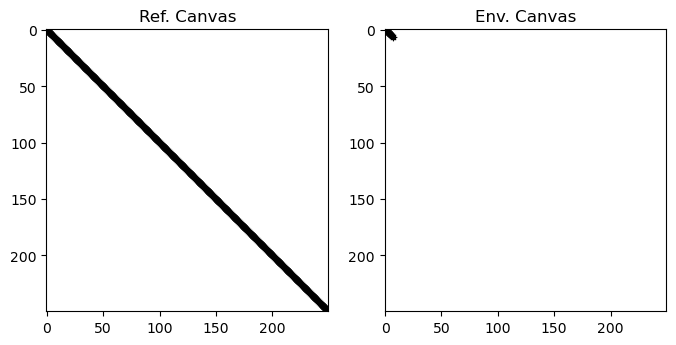

In [68]:
trainer._env.render()

In [44]:
trainer._env.ref_canvas

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]], dtype=float32)